# Loading Pretrained Checkpoints and Predicting Next Steps

This tutorial notebook will show you how to load pretrained BrainLM_MAE models and predict the next X timepoints.

In [1]:
# Inbuilt Python libraries
import os
from random import randint

# Third party library imports
import umap
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_from_disk

# Imports for model from local definition
from brainlm_mae.modeling_brainlm import BrainLMForPretraining

/gpfs/gibbs/project/dijk/sr2464/conda_envs/brainlm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if not os.path.exists("plots"):
    os.mkdir("plots")  # Creates folder called plots in root of project for saving plots

## Load Pretrained Model Checkpoint

In [3]:
checkpoint_path = "/home/sr2464/Desktop/BrainLM/training-runs/2023-04-21-10_29_26/checkpoint-181"
model = BrainLMForPretraining.from_pretrained(checkpoint_path)
print(model)

You are using a model of type brainlm_mae to instantiate a model of type vit_mae. This is not supported for all configurations of models and can yield errors.


BrainLMForPretraining(
  (vit): BrainLMModel(
    (embeddings): BrainLMEmbeddings(
      (patch_embeddings): None
      (signal_embedding_projection): Linear(in_features=1, out_features=128, bias=True)
      (xyzt_embedding_projection): Linear(in_features=4, out_features=128, bias=True)
    )
    (encoder): ViTMAEEncoder(
      (layer): ModuleList(
        (0): ViTMAELayer(
          (attention): ViTMAEAttention(
            (attention): ViTMAESelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ViTMAESelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTMAEIntermediate(

In [4]:
# View model config
model.config

ViTMAEConfig {
  "_name_or_path": "/home/sr2464/Desktop/BrainLM/training-runs/2023-04-21-10_29_26/checkpoint-181",
  "architectures": [
    "BrainLMForPretraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "decoder_hidden_size": 128,
  "decoder_intermediate_size": 512,
  "decoder_num_attention_heads": 4,
  "decoder_num_hidden_layers": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 128,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "loss_fn": "mse",
  "mask_ratio": 0.5,
  "model_type": "vit_mae",
  "norm_pix_loss": false,
  "num_attention_heads": 4,
  "num_channels": 3,
  "num_hidden_layers": 4,
  "patch_size": 16,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.28.0.dev0"
}

## Load Dataset

In [5]:
test_ds_path = "/home/sr2464/palmer_scratch/datasets/UKBioBank1000_Arrow_global_normalization/test_ukbiobank1000"
test_ds = load_from_disk(test_ds_path)
print(test_ds)

Dataset({
    features: ['Raw Recording', 'Normalized Recording', 'Filename', 'Patient ID'],
    num_rows: 100
})


In [6]:
example1 = test_ds[0]
print(np.array(example1["Normalized Recording"]).shape)

(490, 424)


In [7]:
coords_ds_path = "/home/sr2464/palmer_scratch/datasets/UKBioBank1000_Arrow/Brain_Region_Coordinates"
coords_ds = load_from_disk(coords_ds_path)
print(coords_ds)

Dataset({
    features: ['Index', 'X', 'Y', 'Z'],
    num_rows: 424
})


## Preprocessing Function and Sample Creation

In [8]:
recording_col_name = "Normalized Recording"
moving_window_len = 10

In [9]:
def collate_fn(examples):
    """
    This function tells the dataloader how to stack a batch of examples from the dataset.
    Need to stack gene expression vectors and maintain same argument names for model inputs
    which CellLM is expecting in forward() function:
        expression_vectors, sampled_gene_indices, and cell_indices
    """
    labels = torch.zeros(len(examples["xyzt_vectors"]), dtype=torch.float32)

    # These inputs will go to model.forward(), names must match
    return {
        "signal_vectors": examples["signal_vectors"][0].unsqueeze(0),
        "xyzt_vectors": examples["xyzt_vectors"][0].unsqueeze(0),
        "input_ids": examples["signal_vectors"][0].unsqueeze(0),
        "labels": labels
    }

In [10]:
def preprocess_images(examples):
    """
    Preprocessing function for dataset samples. This function is passed into Trainer as
    a preprocessor which takes in one row of the loaded dataset and constructs a model
    input sample according to the arguments which model.forward() expects.

    The reason this function is defined inside on main() function is because we need
    access to arguments such as cell_expression_vector_col_name.
    """
    #
    signal_val_list = []
    xyzt_list = []

    for idx, signal_vector in enumerate(examples[recording_col_name]):
        # signal_vector is list of lists of shape [num_timepoints x 424]
        signal_vector = torch.tensor(signal_vector, dtype=torch.float32)

        # Choose random starting index, take window of moving_window_len points for each region
        start_idx = randint(0, signal_vector.shape[0] - moving_window_len)
        end_idx = start_idx + moving_window_len

        # Append signal values and coords
        window = signal_vector[start_idx: end_idx, :]  # [moving_window_len, 424]
        for brain_region_idx in range(window.shape[1]):
            for idx, timepoint_idx in enumerate(range(start_idx, end_idx)):
                xyz = torch.tensor([
                    coords_ds[brain_region_idx]["X"],
                    coords_ds[brain_region_idx]["Y"],
                    coords_ds[brain_region_idx]["Z"]], dtype=torch.float32)
                xyzt = torch.cat([xyz, torch.tensor([timepoint_idx], dtype=torch.float32)])
                xyzt_list.append(xyzt)

                signal_val = window[idx, brain_region_idx]
                signal_val_list.append(torch.tensor([signal_val], dtype=torch.float32))

    # Add in key-value pairs for model inputs which CellLM is expecting in forward() function:
    #  signal_vectors and xyzt_vectors
    #  These lists will be stacked into torch Tensors by collate() function (defined above).
    examples["signal_vectors"] = [torch.stack(signal_val_list, dim=0)]
    examples["xyzt_vectors"] = [torch.stack(xyzt_list, dim=0)]
    return examples

Forward 1 sample through BrainLM model

In [11]:
example = test_ds[0]

# Wrap each value in the key:value pairs into a list (expected by preprocess() and collate())
example["Normalized Recording"] = [example["Normalized Recording"]]

processed_example = preprocess_images(
    examples=example

)  # preprocess samples genes, adds keys, etc
model_inputs = collate_fn(processed_example)
print(model_inputs)


{'signal_vectors': tensor([[[0.4930],
         [0.5399],
         [0.5775],
         ...,
         [0.6924],
         [0.8616],
         [0.7620]]]), 'xyzt_vectors': tensor([[[ 14., -78.,   4.,  21.],
         [ 14., -78.,   4.,  22.],
         [ 14., -78.,   4.,  23.],
         ...,
         [ 22., -38., -46.,  28.],
         [ 22., -38., -46.,  29.],
         [ 22., -38., -46.,  30.]]]), 'input_ids': tensor([[[0.4930],
         [0.5399],
         [0.5775],
         ...,
         [0.6924],
         [0.8616],
         [0.7620]]]), 'labels': tensor([0.])}


In [12]:
print(model_inputs["signal_vectors"].shape)
print(model_inputs["xyzt_vectors"].shape)

torch.Size([1, 4240, 1])
torch.Size([1, 4240, 4])


In [13]:
model.vit.embeddings.mask_for_inference = True

In [14]:
vitmae_for_pre_training_output = model(
    signal_vectors=model_inputs["signal_vectors"],
    xyzt_vectors=model_inputs["xyzt_vectors"],
    labels=model_inputs["labels"],
    input_ids=model_inputs["input_ids"]
)
print(vitmae_for_pre_training_output.keys())

Custom inference masking...
odict_keys(['loss', 'logits', 'mask', 'ids_restore'])


In [15]:
vitmae_for_pre_training_output["loss"]

tensor(0.0492, grad_fn=<DivBackward0>)

In [16]:
vitmae_for_pre_training_output["logits"].shape

torch.Size([1, 4240, 1])

In [17]:
print(vitmae_for_pre_training_output["mask"].shape)
print(vitmae_for_pre_training_output["mask"][0, :12])

torch.Size([1, 4240])
tensor([0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0.])


In [21]:
preds = vitmae_for_pre_training_output["logits"][0, :, 0].detach().cpu().numpy()
print(preds.shape)
gt = model_inputs["signal_vectors"][0, :, 0].detach().cpu().numpy()
print(gt.shape)

(4240,)
(4240,)


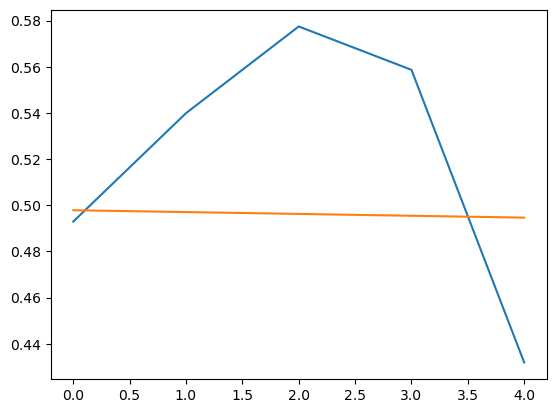

In [22]:
plt.plot(gt[:5], label="Input Data")
plt.plot(preds[5:10], label="Prediction")
plt.show()

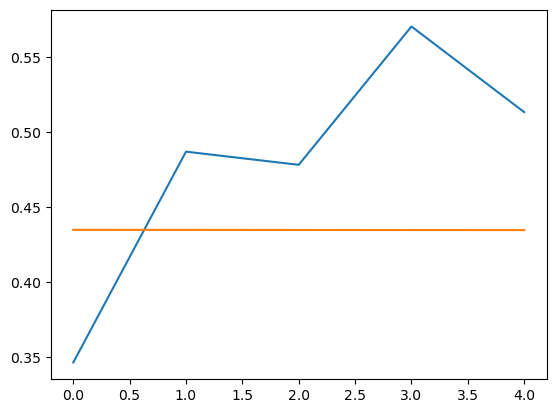

In [24]:
plt.plot(gt[110:115], label="Input Data")
plt.plot(preds[115:120], label="Prediction")
plt.show()